In [1]:
!pwd

/home/gadalf/Python/Machine_learning_Deep_learning/cnn


# CNN for skin cancer detection
Skin cancer is an import human malignancy, with professionals diagnosing it visually. This include clinical screeening and dermoscopic analysis, a biopsy and histopathological examination. Automatising the skin lesions using images is an approach, developed in the past and using convolution neural networks.

The dataset is taken from the ISIC (International Skin Image Collaboration) Archive following the example in 
- kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000/data 

- kaggle.com/code/fanconic/cnn-for-skin-cancer-detection/notebook

- kaggle.com/code/sid321axn/step-wise-approach-cnn-model-77-0344-accuracy/input?select=HAM10000_images_part_1

It consists 1800 pictures of benign moles and 1497 pictures of malignant classified moles. The pictures size to  (224x224x3) RGB.

Objective: Create a model/kernel to classify a mole visually into benign and malignant and also predict yours.

1) Importing necessary libs
Including TensorFlow backend, keras etc.

In [3]:
!pip3 install -q tensorflow

In [4]:
!pip3 install -q keras-utils

In [5]:
!pip3 install -q cloudpickle

In [6]:
!pip3 install -q scikeras

In [7]:
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(7) 

from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
import itertools

import keras
from keras.utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
from keras.layers import Normalization
from keras.utils import to_categorical # convert to one-hot-encoding
from keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.callbacks import ReduceLROnPlateau
from keras.applications.resnet_v2 import ResNet50V2
from keras import backend as K

2025-07-11 08:48:18.986510: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752220099.029429    2047 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752220099.044125    2047 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752220099.075099    2047 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752220099.075123    2047 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752220099.075129    2047 computation_placer.cc:177] computation placer alr

In [8]:
#1. Function to plot model's validation loss and validation accuracy
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

2. Loading the images and creating dictionary of images and add labels
Convert to np arrays using their RGB values.

 Create the image path dictionary by joining the folder path from base directory base_skin_dir and merge the images in jpg format from both the folders HAM10000_images_part1.zip and HAM10000_images_part2.zip

In [23]:
base_skin_dir = os.path.join('..', './input/archive/')

# Merging images from both folders HAM10000_images_part1.zip and HAM10000_images_part2.zip into one dictionary

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

# This dictionary is useful for displaying more human-friendly labels later on

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}


3. Reading & Processing the data
- Reading the csv by joining the path of the input folder which is the base directory where all the extracted images exist.
- Creating new columns to increase interpretability (image<id, cell_type for the short name name of lesion type and the categorical column to dinstiguish codes from 0 to 6>)

In [24]:
skin_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))

# Creating new columns to increase interpretability
skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

In [25]:
skin_df.head(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,.././input/archive/ham10000_images_part_1/ISIC...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,.././input/archive/ham10000_images_part_1/ISIC...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,.././input/archive/ham10000_images_part_1/ISIC...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,.././input/archive/ham10000_images_part_1/ISIC...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,.././input/archive/ham10000_images_part_2/ISIC...,Benign keratosis-like lesions,2


4. Data Cleaning
Check for missing values and datatype of each field

In [26]:
skin_df.isnull().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

As seen there are 57 null values in the age, an option is to fill the null values by their mean.

In [27]:
skin_df['age'].fillna((skin_df['age'].mean()), inplace=True)

In [28]:
skin_df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
path             0
cell_type        0
cell_type_idx    0
dtype: int64

In [29]:
skin_df.shape

(10015, 10)

In [30]:
skin_df.dtypes

lesion_id         object
image_id          object
dx                object
dx_type           object
age              float64
sex               object
localization      object
path              object
cell_type         object
cell_type_idx       int8
dtype: object

5. EDA
Exploring different features of the df, their distributions and actual counts

<Axes: xlabel='cell_type'>

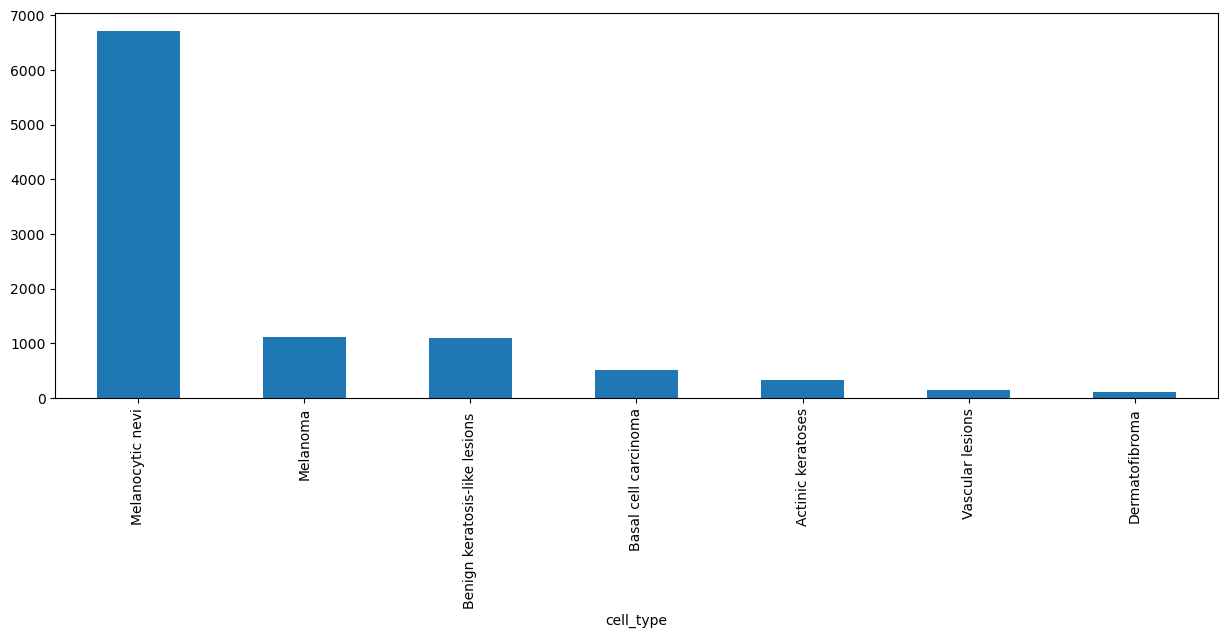

In [31]:
fig, axs = plt.subplots(1, 1, figsize=(15, 5))
skin_df['cell_type'].value_counts().plot(kind='bar', ax=axs)

- Melanecytic nevi has very large number of instances in comparison to other cell types.

Lets examine the technical validation field which is dx_type to see the distribution of the 4 categories as below:

1. Histopathology: Diagnoses of excised lesions have been performed by specialized dermatopathologists.
2. Confocal: Reflectance confocal microscopy is an in-vivo imaging technique with a resolution at near-cellular level, and some facial benign with a grey-world assumption of all training-set images in Lab-color space before and after manual histogram changes.
3. Follow-up: If nevi monitored by digital dermatoscopy did not show any changes during 3 follow-up visits or 1.5 years biologists accepted this as evidence of biologic benignity. Only nevi, but no other benign diagnoses were labeled with this type of ground-truth because dermatologists usually do not monitor dermatofibromas, seborrheic keratoses, or vascular lesions.
4. Consensus: For typical benign cases without histopathology or followup biologists provide an expert-consensus rating of authors PT and HK. They applied the consensus label only if both authors independently gave the same unequivocal benign diagnosis. Lesions with this type of groundtruth were usually photographed for educational reasons and did not need further follow-up or biopsy for confirmation.

<Axes: xlabel='dx_type'>

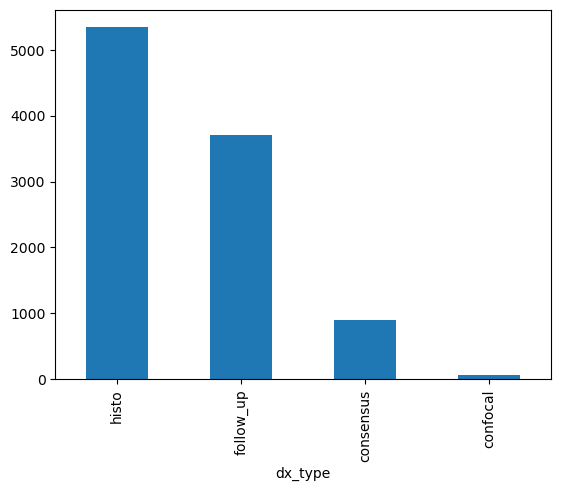

In [32]:
skin_df['dx_type'].value_counts().plot(kind='bar')

<Axes: xlabel='localization'>

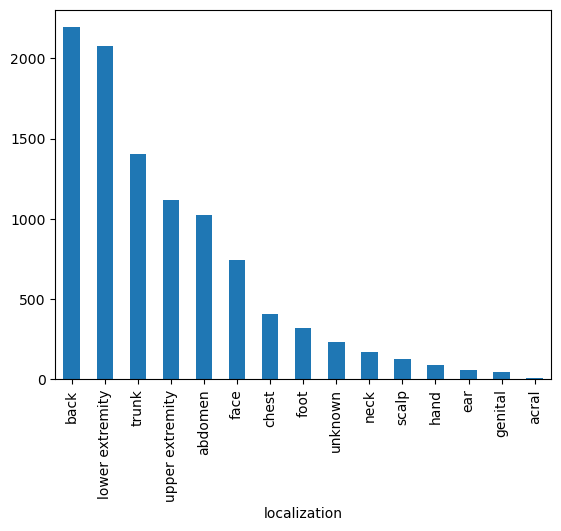

In [33]:
skin_df['localization'].value_counts().plot(kind='bar')

Back, lower extremity, trunk and upper extremity are the most common locations for skin lesions in this dataset.

<Axes: >

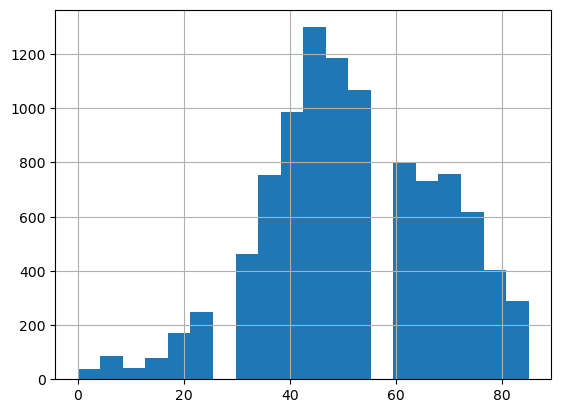

In [34]:
skin_df['age'].hist(bins=20)

There are larger instances of patients having age from 30 to 60

<Axes: xlabel='sex'>

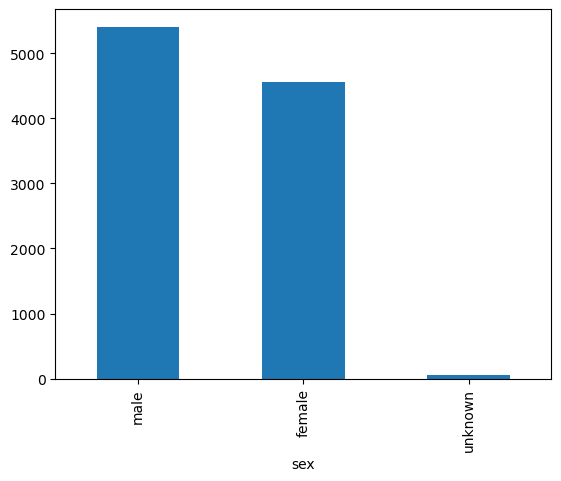

In [35]:
skin_df['sex'].value_counts().plot(kind='bar')

Males show a higher distribution

<Axes: xlabel='age', ylabel='cell_type_idx'>

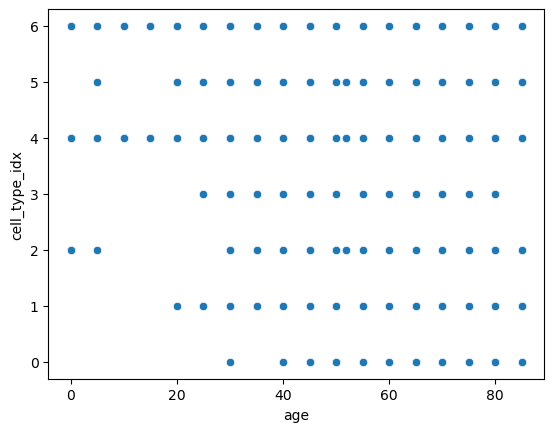

In [36]:
sns.scatterplot(x=skin_df['age'], y=skin_df['cell_type_idx'])

Skin cancer types 0,1, 3 and 5 which denote Melanocytic nevi,dermatofibroma, Basal cell carcinoma and Vascular lesions are not much prevalant below the age of 20 years

/home/gadalf/Apps/anaconda/3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/gadalf/Apps/anaconda/3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


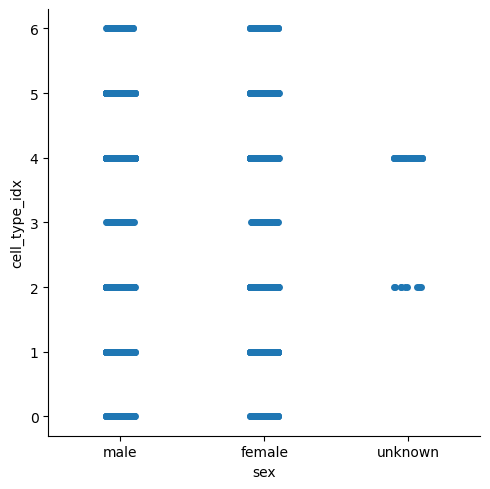

In [37]:
sns.catplot(x=skin_df['sex'], y=skin_df['cell_type_idx'])

Sexwise distribution of skin cancer type



6. Loading and resizing the images
 The images are loaded into the column named image from the image path. Resizing is performed by the images as the original dimension of images are 450 x 600 x3 which TensorFlow can't handle, so that's why we resize it into 100 x 75. As this step resize all the 10015 images dimensions into 100x 75 so be patient it will take some time.

In [38]:
#Adding the image column to the datafram
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

In [41]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,.././input/archive/ham10000_images_part_1/ISIC...,Benign keratosis-like lesions,2,"[[[190, 153, 194], [192, 154, 196], [191, 153,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,.././input/archive/ham10000_images_part_1/ISIC...,Benign keratosis-like lesions,2,"[[[23, 13, 22], [24, 14, 24], [25, 14, 28], [3..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,.././input/archive/ham10000_images_part_1/ISIC...,Benign keratosis-like lesions,2,"[[[185, 127, 137], [189, 133, 147], [194, 136,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,.././input/archive/ham10000_images_part_1/ISIC...,Benign keratosis-like lesions,2,"[[[24, 11, 17], [26, 13, 22], [38, 21, 32], [5..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,.././input/archive/ham10000_images_part_2/ISIC...,Benign keratosis-like lesions,2,"[[[134, 90, 113], [147, 102, 125], [159, 115, ..."


Lets see sample of images

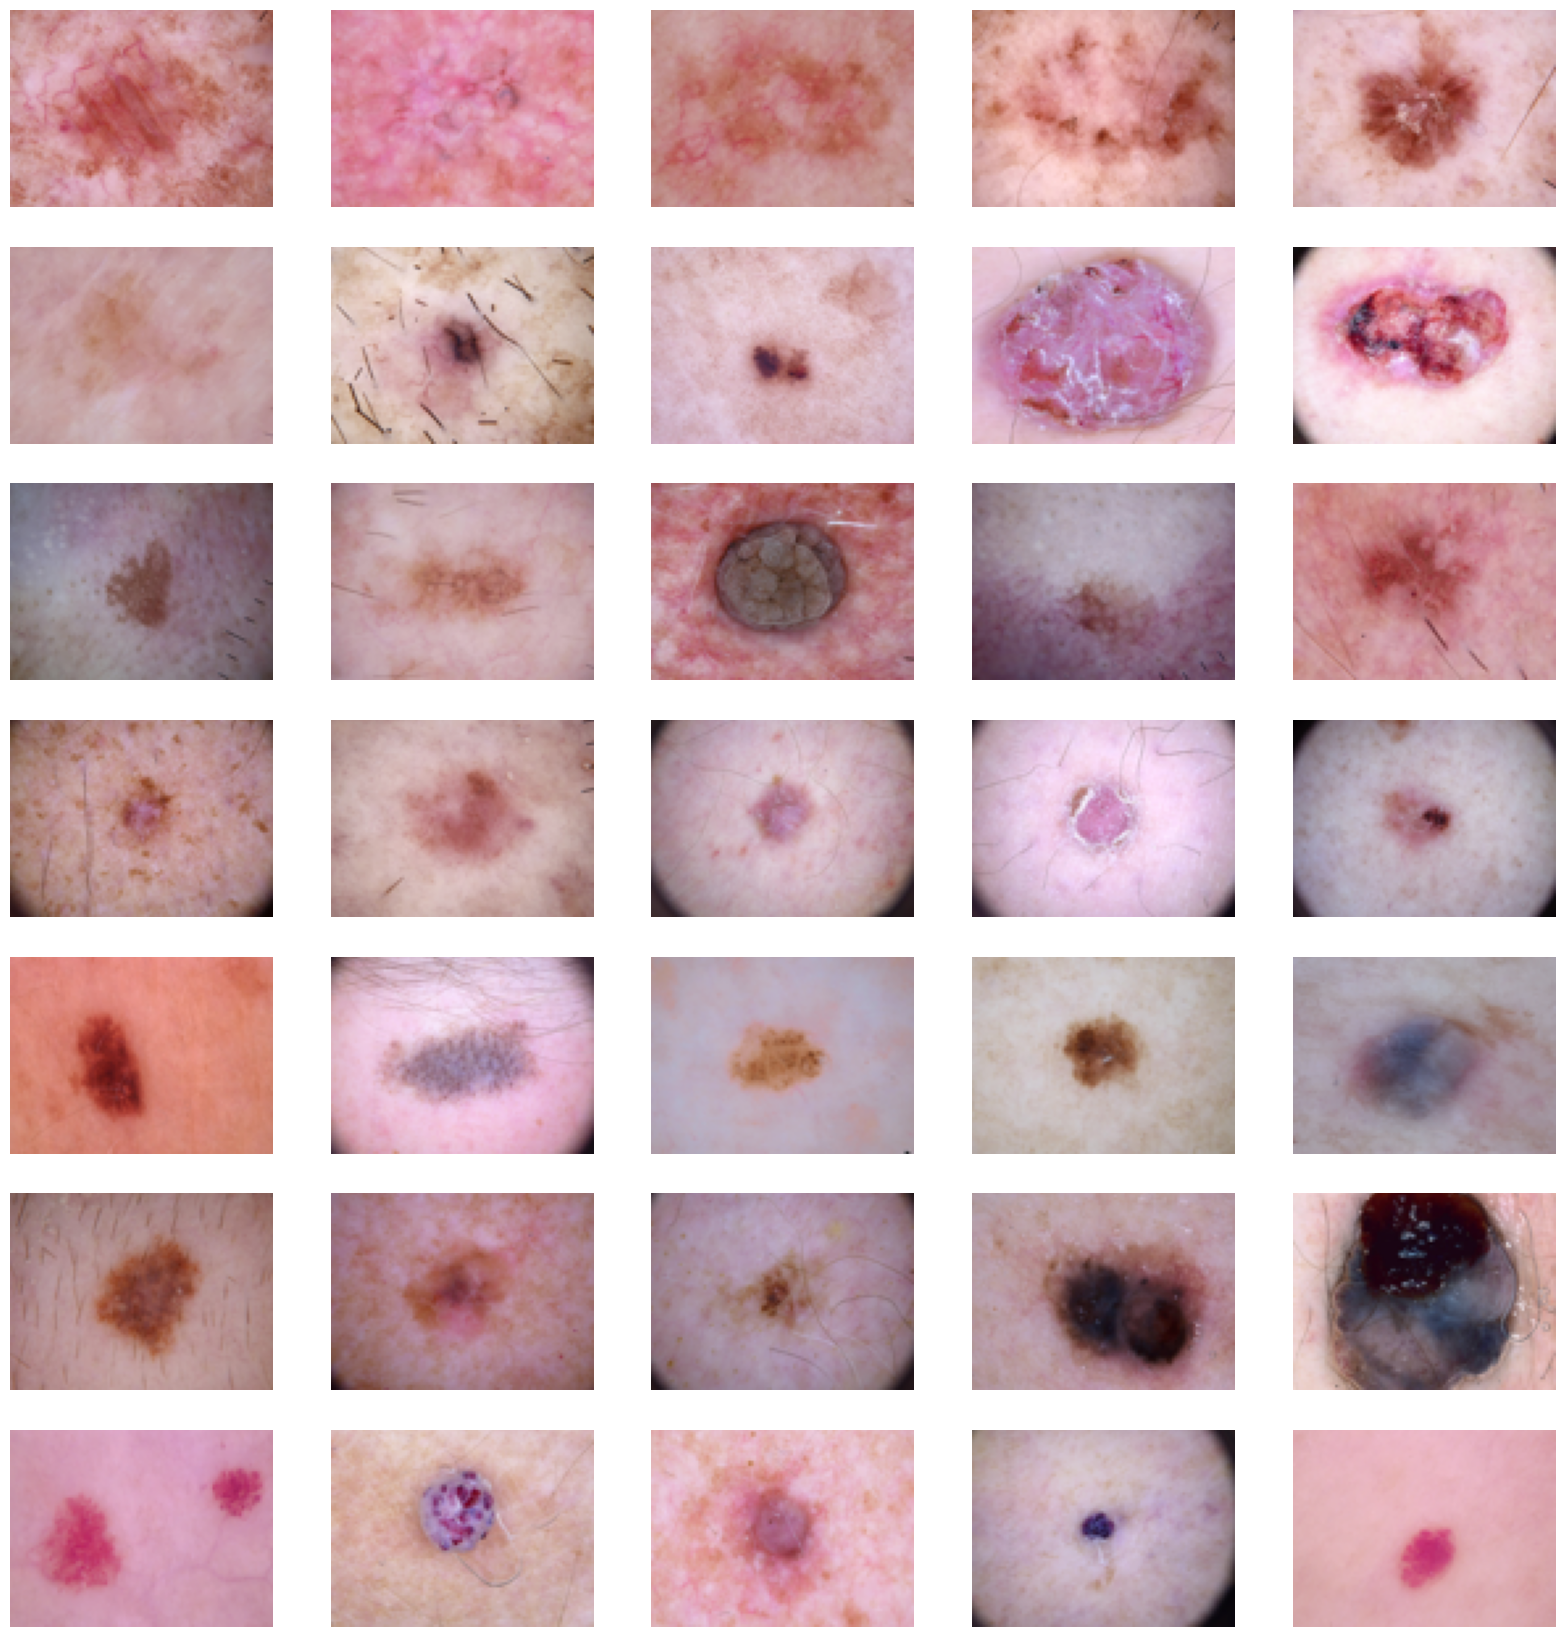

In [42]:
n_samples = 5
fig, axs = plt.subplots(7, n_samples, figsize=(4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(axs,skin_df.sort_values(['cell_type_idx']).groupby('cell_type')):
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

In [43]:
# Checking the image size distribution
skin_df['image'].map(lambda x: x.shape).value_counts()

image
(75, 100, 3)    10015
Name: count, dtype: int64

In [44]:
features=skin_df.drop(columns=['cell_type_idx'],axis=1)
target=skin_df['cell_type_idx']

7. Perform train test split step
Split the data into training and testing sets to train and evaluate the model. The test size is set to 20% of the total data, and a random state is specified for reproducibility.

In [45]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

8. Normalisation
This step is to normalize the x_train, x_test by substracting from theor mean values and then dividing by thier standard deviation. This step helps the model, normalises the data and easier to handle.

In [46]:
x_train = np.asarray(x_train['image'].tolist())
x_test = np.asarray(x_test['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

9. Adding labels (label encoding)
7 different classes of skin cance types from 0 to 6 form the labels. These need to be encoded to one hot vectors

In [47]:
# Performe the one-hot encoding on the labels
y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

In [48]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 2)

In [49]:
# Reshape image in 3 dimensions (height = 75px, width = 100px , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

11. Building the CNN model
 The Keras Sequential API is used to add one layer at a time, starting from input

The architecture of the model is inhereted from the example:

The first is the convolutional (Conv2D) layer. It is like a set of learnable filters. The 32 filters are chosen for the two firsts conv2D layers and 64 filters for the two last ones. Each filter transforms a part of the image (defined by the kernel size) using the kernel filter. The kernel filter matrix is applied on the whole image. Filters can be seen as a transformation of the image.

The CNN can isolate features that are useful everywhere from these transformed images (feature maps).

The second important layer in CNN is the pooling (MaxPool2D) layer. This layer simply acts as a downsampling filter. It looks at the 2 neighboring pixels and picks the maximal value. These are used to reduce computational cost, and to some extent also reduce overfitting. We have to choose the pooling size (i.e the area size pooled each time) more the pooling dimension is high, more the downsampling is important.

Combining convolutional and pooling layers, CNN are able to combine local features and learn more global features of the image.

Dropout is a regularization method, where a proportion of nodes in the layer are randomly ignored (setting their wieghts to zero) for each training sample. This drops randomly a propotion of the network and forces the network to learn features in a distributed way. This technique also improves generalization and reduces the overfitting.

`relu` is the rectifier (activation function max(0,x). The rectifier activation function is used to add non linearity to the network.

The Flatten layer is use to convert the final feature maps into a one single 1D vector. This flattening step is needed so that you can make use of fully connected layers after some convolutional/maxpool layers. It combines all the found local features of the previous convolutional layers.

In the end, the features in two fully-connected (Dense) layers which is just artificial neural networks (ANN) classifier is used. In the last layer(Dense(10,activation="softmax")) the net outputs distribution of probability of each class.

In [50]:
# Set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out
input_shape = (75, 100, 3)
num_classes = 7

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.40))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

/home/gadalf/Apps/anaconda/3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
W0000 00:00:1752221738.757467    2047 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 75, 100, 32)    │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 100, 32)    │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 37, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 37, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 37, 50, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 18, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 18, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 28800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,686,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,752,999 (14.32 MB)

 Trainable params: 3,752,999 (14.32 MB)

 Non-trainable params: 0 (0.00 B)

12 Setting the optimizer and annealer

Once our layers are added to the model, we need to set up a score function, a loss function and an optimisation algorithm. We define the loss function to measure how poorly our model performs on images with known labels. It is the error rate between the oberved labels and the predicted ones. We use a specific form for categorical classifications (>2 classes) called the "categorical_crossentropy". The most important function is the optimizer. This function will iteratively improve parameters (filters kernel values, weights and bias of neurons ...) in order to minimise the loss. I choosed Adam optimizer because it combines the advantages of two other extensions of stochastic gradient descent. Specifically:

Adaptive Gradient Algorithm (AdaGrad) that maintains a per-parameter learning rate that improves performance on problems with sparse gradients (e.g. natural language and computer vision problems).

Root Mean Square Propagation (RMSProp) that also maintains per-parameter learning rates that are adapted based on the average of recent magnitudes of the gradients for the weight (e.g. how quickly it is changing). This means the algorithm does well on online and non-stationary problems (e.g. noisy).

Adam realizes the benefits of both AdaGrad and RMSProp.

Adam is a popular algorithm in the field of deep learning because it achieves good results fast.

The metric function "accuracy" is used is to evaluate the performance our model. This metric function is similar to the loss function, except that the results from the metric evaluation are not used when training the model (only for evaluation).

In [51]:
# Define the optimizer
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, amsgrad=False)

In [52]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [53]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In order to make the optimizer converge faster and closest to the global minimum of the loss function, i used an annealing method of the learning rate (LR).

The LR is the step by which the optimizer walks through the 'loss landscape'. The higher LR, the bigger are the steps and the quicker is the convergence. However the sampling is very poor with an high LR and the optimizer could probably fall into a local minima.

Its better to have a decreasing learning rate during the training to reach efficiently the global minimum of the loss function.

To keep the advantage of the fast computation time with a high LR, i decreased the LR dynamically every X steps (epochs) depending if it is necessary (when accuracy is not improved).

With the ReduceLROnPlateau function from Keras.callbacks, i choose to reduce the LR by half if the accuracy is not improved after 3 epochs.

#### Data Augmentation
It is the optional step. In order to avoid overfitting problem, we need to expand artificially our HAM 10000 dataset. We can make your existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations

Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more.

By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.

In [54]:
# With data augmentation to prevent overfitting 

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

For the data augmentation, it has been chosen:
 Randomly rotate some training images by 10 degrees Randomly Zoom by 10% some training images Randomly shift images horizontally by 10% of the width Randomly shift images vertically by 10% of the height Once our model is ready, we fit the training dataset .

13. Fitting the model
Final step, I fit the model into x_train, y_train. In this step I have choosen batch size of 10 and 50 epochs as small as your batch size will be more efficiently your model will train and I have choosen 50 epochs to give the model sufficient epochs to train

In [56]:
# Fit the model
epochs = 50 
#batch_size = 10
#history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
#                    epochs = epochs,
#                    validation_data = (x_validate,y_validate),
#                    verbose = 1,
#                    steps_per_epoch=x_train.shape[0] // batch_size,
#                    callbacks=[learning_rate_reduction])
datagen = ImageDataGenerator(
    rotation_range=90,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

datagen.fit(x_train)

import tensorflow
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=tensorflow.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

batch_size = 32

training_history = model.fit(
    datagen.flow(x_train, y_train, batch_size=batch_size),
    steps_per_epoch=len(x_train) // batch_size,
    epochs=epochs
)

Epoch 1/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 93s 407ms/step - accuracy: 0.6729 - loss: 0.9499
Epoch 2/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 47us/step - accuracy: 0.7188 - loss: 0.6609   
Epoch 3/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 101s 449ms/step - accuracy: 0.6662 - loss: 0.8957
Epoch 4/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 36us/step - accuracy: 0.6562 - loss: 1.0638   
Epoch 5/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 84s 371ms/step - accuracy: 0.6833 - loss: 0.8662
Epoch 6/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 61us/step - accuracy: 0.8125 - loss: 0.6217   
Epoch 7/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 85s 376ms/step - accuracy: 0.6936 - loss: 0.8419
Epoch 8/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 56us/step - accuracy: 0.7812 - loss: 0.6439   
Epoch 9/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 85s 376ms/step - accuracy: 0.6933 - loss: 0.8456
Epoch 10/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 66us/step - accuracy: 0.7812 - loss: 0.5174   
Epoch 11/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 86s 380ms/step - accuracy: 0.6959 - loss: 0.8096
Epoch 12/50
2

Step 14. Model Evaluation
Check the testing accuracy and validation accuracy of our model,plot confusion matrix and also check the missclassified images count of each type

In [57]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))
model.save("model.h5")

63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.7397 - loss: 0.7207
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.7323 - loss: 0.7436


Validation: accuracy = 0.730673  ;  loss_v = 0.747024
Test: accuracy = 0.746880  ;  loss = 0.693802


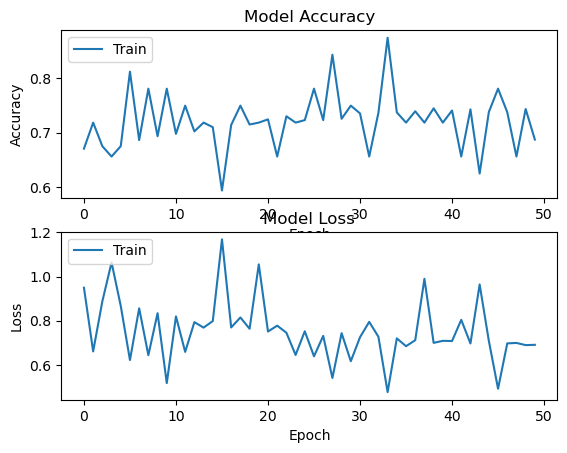

In [60]:
#plot_model_history(history)
# Assuming 'history' is the history object returned by model.fit()
plt.figure(1)
# Plot training & validation accuracy
plt.subplot(211)
plt.plot(training_history.history['accuracy'])
#plt.plot(training_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss
plt.subplot(212)
plt.plot(training_history.history['loss'])
#plt.plot(training_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step


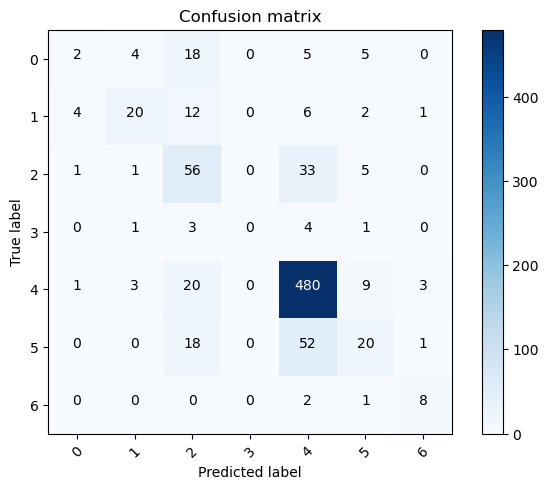

In [61]:
from sklearn.metrics import confusion_matrix
# Function to plot confusion matrix    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(x_validate)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_validate,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7)) 


Lets find the category has much incorrect predictions

Text(0, 0.5, 'Fraction classified incorrectly')

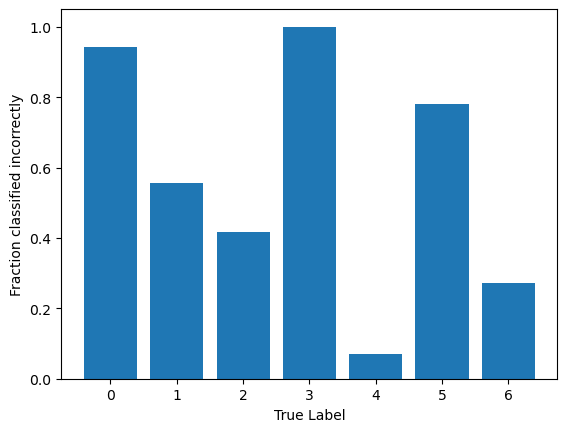

In [62]:
label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
plt.bar(np.arange(7),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')

Summary:
The model has maximum number of incorrect predictions for Basal cell carcinoma which has code 3, 
then second most missclassified type is Vascular lesions code 5 then Melanocytic nevi code 0 where as Actinic keratoses code 4 has least misclassified type.

We can also further tune our model to easily achieve the accuracy above 80% and I think still this model is efficient in comparison to detection with human eyes having 77.0344% accuracy

I hope kagglers like my stepwise approach to classify cancer types. If like then kindly dont forget to hit the like